In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [99]:
import psycopg2
import os
from urllib.parse import urlparse
    
# pyodbc connection string
# connection_string = "Driver={Amazon Redshift (x64)}; Server=openalex-4.cnw77bm9bpcp.us-east-1.redshift.amazonaws.com; Database=dev; UID=awsuser; PWD=CraftRamen42!; Port=5439"
# conn = pyodbc.connect(connection_string, autocommit=True)

connection_string = urlparse(os.getenv("DATABASE_URL_OPENALEX_REDSHIFT"))
username = connection_string.username
password = connection_string.password
database = connection_string.path[1:]
hostname = connection_string.hostname
port = connection_string.port

conn = psycopg2.connect(
    database = database,
    user = username,
    password = password,
    host = hostname,
    port = port
)


In [225]:

# SQL query to Dremio
sql_query = r""" SELECT * 
    FROM util.temp_data_estimated_citation 
    where citation_count > 0
    order by random() 
    limit 10000"""

df = pd.read_sql(sql_query, conn)


array([[<AxesSubplot:title={'center':'paper_id'}>,
        <AxesSubplot:title={'center':'citation_count'}>,
        <AxesSubplot:title={'center':'estimated_citation'}>],
       [<AxesSubplot:title={'center':'years_old'}>,
        <AxesSubplot:title={'center':'reference_count'}>,
        <AxesSubplot:title={'center':'num_authors'}>],
       [<AxesSubplot:title={'center':'journal_id'}>,
        <AxesSubplot:title={'center':'multiplier'}>, <AxesSubplot:>]],
      dtype=object)

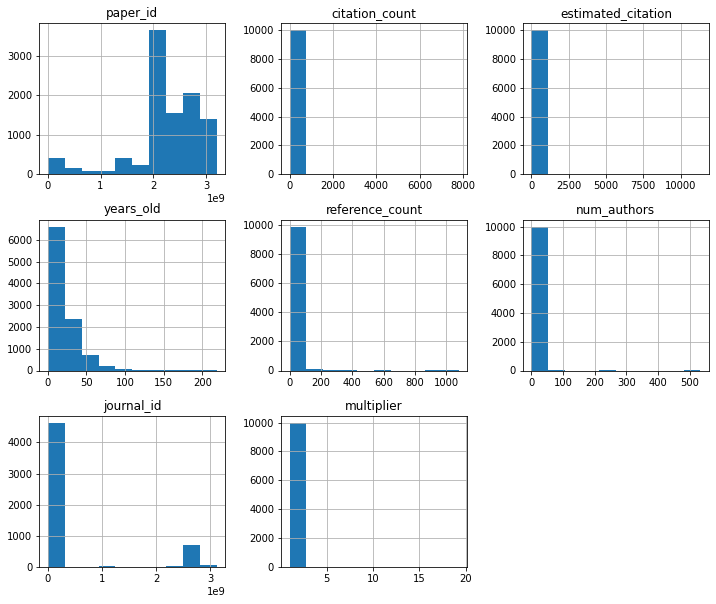

In [226]:
df.hist(figsize=(12,10))


In [227]:
df

,paper_id,citation_count,estimated_citation,years_old,genre,reference_count,num_authors,journal_id,display_name,publisher,multiplier
0,2611758569,10,10,4,journal-article,20,6.0,5.316237e+07,Journal of the American Ceramic Society,Wiley,1.00
1,2417187727,5,5,37,None,0,3.0,8.739398e+07,Cutis,None,1.00
2,2215318695,1,1,63,journal-article,0,1.0,5.001666e+07,American Journal of Ophthalmology,Elsevier,0.99
3,2745359321,1,1,11,None,0,5.0,NaN,None,None,0.99
4,2767640137,1,1,7,None,49,1.0,NaN,None,None,0.99
...,...,...,...,...,...,...,...,...,...,...,...
9995,2848135004,1,1,11,None,0,2.0,NaN,None,None,0.99
9996,2090763524,97,97,12,journal-article,42,9.0,1.995727e+08,Journal of Neuroinflammation,Springer Nature,1.00
9997,2542083267,1,1,4,reference-entry,0,2.0,NaN,None,None,0.99
9998,2910613135,2,2,3,None,0,3.0,2.764958e+09,Remote Sensing Technology and Application,None,1.00


/Users/hpiwowar/.pyenv/versions/3.9.5/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


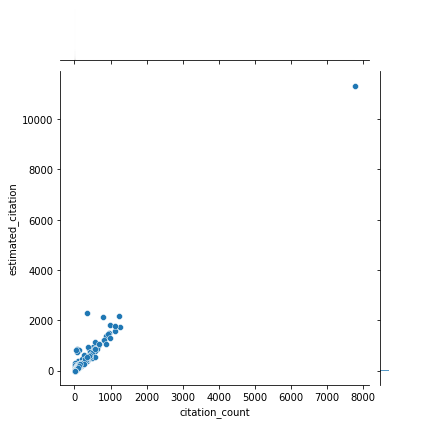

In [228]:
# df.drop(['dteday', 'instant'], axis=1, inplace=True)
sns.jointplot('citation_count','estimated_citation', data=df)

<AxesSubplot:>

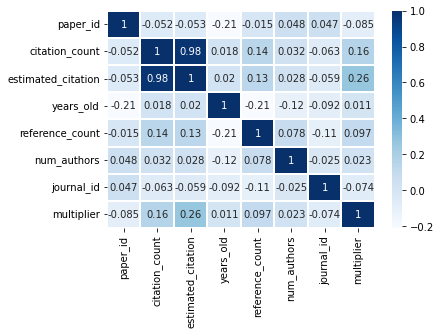

In [229]:
sns.heatmap(df.corr(), annot=True, linewidth=2, cmap=plt.cm.Blues)


In [502]:
import math

df = pd.read_sql(sql_query, conn)

# - single author or not
# - log years since published
# - is it a book, monograph, report, or book-chapter
# - is it a journal-article (because interacts with publishers and big journals below)
# - is it a big publisher
# - lookup for big journals , maybe using 122 journals with avg multiplier in the last 10 years with multiplier over 1.05

journals = """64187185
125754415
3121261024
21442059
1010394304
3880285
9692511
13479253
24807848
45305740
98026630
111155417
2493613807
140251998
104917558
49861241
109565702
177147899""".split()

publishers = """Society for Neuroscience
Association for Computing Machinery
Journal of Bone and Joint Surgery
American Diabetes Association
American Society for Microbiology
American Economic Association
American Psychological Association
EMBO
Institute for Operations Research and the Management Sciences
Cold Spring Harbor Laboratory
The Endocrine Society
The Rockefeller University Press
American Society for Clinical Investigation
The American Association of Immunologists
Annual Reviews
Ovid Technologies Wolters Kluwer -American Heart Association
Proceedings of the National Academy of Sciences""".split()

df['log_citation_count'] = [math.log10(count+1.0) for count in df['citation_count']]
df['log_estimated_citation'] = [math.log10(count+1.0) for count in df['estimated_citation']]

if True:
    df['log_years_old'] = [math.log10(age+1.0) for age in df['years_old']]
    # df['log_num_authors'] = np.log(df.num_authors+0.01)
#     df['is_single_author'] = [1 if n > 1 else 0 for n in df['num_authors']]
#     df['has_references'] = [1 if n > 1 else 0 for n in df['reference_count']]
    # df['log_reference_count'] = np.log(df.reference_count+0.01)
#     df['is_journal'] = [1 if g == 'journal-article' else 0 for g in df['genre']]
#     df['is_other_cited_genre'] = [1 if g in ['book', 'report', 'monograph', 'book-chapter'] else 0 for g in df['genre']]
#     df['boost_journal'] = [1 if str(j) in journals else 0 for j in df['journal_id']]
    df['big_publisher'] = [1 if p in publishers else 0 for p in df['publisher']]


# df.drop(['years_old', 'reference_count', 'num_authors', 'paper_id', 'genre', 'display_name', 'publisher', 'multiplier', 'journal_id'], axis=1, inplace=True)

# df.drop(['paper_id', 'genre', 'display_name', 'publisher', 'multiplier', 'journal_id'], axis=1, inplace=True)

if False:
    df.drop(['citation_count', 'estimated_citation', 'years_old', 'reference_count', 'num_authors', 'paper_id', 'genre', 'display_name', 'publisher', 'multiplier', 'journal_id'], axis=1, inplace=True)
else:
    df.drop(['citation_count', 'estimated_citation', 'years_old', 'reference_count', 'num_authors', 'paper_id', 'genre', 'display_name', 'publisher', 'multiplier', 'journal_id'], axis=1, inplace=True)
    

In [503]:
df.describe()
  

,log_citation_count,log_estimated_citation,log_years_old,big_publisher
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.857479,0.879959,1.161687,0.000200
std,0.517674,0.562014,0.393456,0.014141
min,0.301030,0.301030,0.000000,0.000000
25%,0.477121,0.477121,0.903090,0.000000
50%,0.698970,0.698970,1.176091,0.000000
75%,1.176091,1.183098,1.447158,0.000000
max,3.814714,4.055225,2.346353,1.000000


In [504]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# data features and target feature

# x = df.drop('estimated_citation', axis=1)
# y = df['estimated_citation']

x = df.drop('log_estimated_citation', axis=1)
y = df['log_estimated_citation']


# split data
x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   random_state=0,
                                                   test_size=0.3)

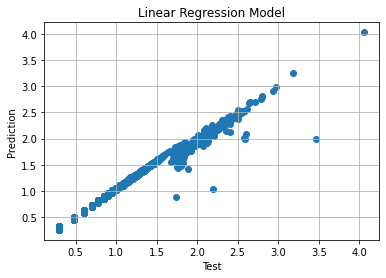

Accuracy metrics:
MAE:  0.03422655554998826
MSE:  0.003833646277256859
Root MSE:  0.061916445935283296
Score:  0.9874562576107611


In [505]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Linear Regression Model

# model and fit
model = LinearRegression(fit_intercept=False)
model.fit(x_train, y_train)
# prediction
predictions = model.predict(x_test)
# plot prediction
plt.scatter(y_test, predictions)
plt.title('Linear Regression Model')
plt.xlabel("Test")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()
# metrics
print('Accuracy metrics:')
print('MAE: ', metrics.mean_absolute_error(y_test, predictions))
print('MSE: ', metrics.mean_squared_error(y_test, predictions))
print('Root MSE: ', np.sqrt(metrics.mean_squared_error(y_test,
                                                      predictions)))
print('Score: ', model.score(x_test, y_test))




In [508]:
model.feature_names_in_

array(['log_citation_count', 'log_years_old', 'big_publisher'],
      dtype=object)

In [509]:
model.coef_


array([ 1.07156829, -0.02960674,  0.07476177])

In [514]:
pow(10, model.predict(np.array([[math.log10(1000), math.log10(10), 1]])))

/Users/hpiwowar/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([1819.11391785])

In [516]:
pow(10, math.log10(1000) * 1.07156829 + math.log10(10) * -0.02960674 + math.log10(10) * 0.07476177)

1819.1139320325215